In [325]:
import ete3
import pandas as pd
import re
import multiprocessing
import numpy as np
import itertools
from scipy.spatial.distance import squareform
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.cluster import hierarchy
from scipy.stats import hypergeom
from sklearn import manifold
import networkx as nx
import community
import random
import collections
import operator
import pickle as pkl
from collections import Counter

%cd /work/kelsey/hgt/

/work/kelsey/hgt


In [2]:
from scipy.spatial.distance import braycurtis

In [3]:
def get_node_age_from_descendants(tree, descendants):
    node = tree.get_common_ancestor(descendants)
    return(node.support)

In [4]:
tree              = ete3.Tree('species_tree')
ranger_named_tree = ete3.Tree('species_tree_named_nodes', format=1)

genomes           = pd.read_csv('../genomes.tab', sep='\t', index_col=0)
genomes.Organism  = genomes.Organism.replace('\s+\(.+\)$', '', regex=True)

transfer_df       = pd.read_csv('transfers-filtered_by_confidence.tab', sep='\t', index_col=0)

name_conversion = {}
for index, row in genomes.iterrows():
    if index.startswith('GC'):
        name_conversion[row.abbreviation] = re.sub('\.\d+$', '', index, flags=re.M).replace('_', '')
    else:
        name_conversion[row.abbreviation] = row.accession.replace('_', '')

for leaf in tree.get_leaves():
    if leaf.name in name_conversion:
        leaf.add_feature('accession', name_conversion[leaf.name])
    else:
        leaf.add_feature('accession', leaf.name.replace('_', ''))

In [5]:
name_table = pd.DataFrame(columns=['name', 'accession'],
                          data=[(leaf.name, leaf.accession) for leaf in tree.get_leaves()])

for node in ranger_named_tree.traverse():
    if node.is_leaf():
        continue

    descendants     = name_table.loc[name_table.accession.isin(node.get_leaf_names()),
                                     'name'].values.tolist()
    equivalent      = tree.get_common_ancestor(descendants)
    equivalent.name = node.name

In [6]:
mol_clock_sample_files = ['Cyano_modelBH_ugam_bd_7_20_sample.datedist',
                          'Cyano_modelBH_cir_bd_7_20_sample.datedist', 
                          'Cyano_modelBH_ln_nobd_7_20_sample.datedist',
                          'Cyano_modelBH_ugam_nobd_7_20_sample.datedist', 
                          'Cyano_modelBH_cir_nobd_7_20_sample.datedist']


In [7]:
mol_clocks = pd.DataFrame(columns=['datedist_file'],
                          data   =mol_clock_sample_files)

mol_clocks['birth_death'] = None
mol_clocks['model']       = None

for index, row in mol_clocks.iterrows():
    if '_bd_' in row.datedist_file:
        mol_clocks.loc[index, 'birth_death'] = True
    else:
        mol_clocks.loc[index, 'birth_death'] = False
        
    tmp_model = re.search('modelBH_([^_]+)_',
                          row.datedist_file).group(1)
    mol_clocks.loc[index, 'model'] = tmp_model

In [8]:
mol_clocks

,datedist_file,birth_death,model
0,Cyano_modelBH_ugam_bd_7_20_sample.datedist,True,ugam
1,Cyano_modelBH_cir_bd_7_20_sample.datedist,True,cir
2,Cyano_modelBH_ln_nobd_7_20_sample.datedist,False,ln
3,Cyano_modelBH_ugam_nobd_7_20_sample.datedist,False,ugam
4,Cyano_modelBH_cir_nobd_7_20_sample.datedist,False,cir


In [9]:
posterior_tree_sample = {}

for datedist in mol_clocks.datedist_file:
    posterior_tree_sample[datedist] = [ete3.Tree(line)
                                 for line in open(
                                     'mol_clock_models/%s' % datedist
                                 ).readlines()]

In [ ]:
for trees1, trees2 in itertools.combinations(posterior_tree_sample.values(), 2):
    for tree1, tree2 in itertools.product(trees1, trees2):
        for node1, node2 in zip(tree1.traverse(), tree2.traverse()):
            if node1.is_leaf() or node2.is_leaf():
                continue
            
            if node1.get_topology_id() != node2.get_topology_id():
                print('fuck')

In [15]:
def compare_br_lengths(nodes):
    node1, node2 = nodes
#    if node1.get_topology_id() != node2.get_topology_id():
#        print('fuck')
    return((node1.dist - node2.dist)**2)

In [ ]:
sse = {}
for (datedist1, trees1), (datedist2, trees2) in itertools.combinations(posterior_tree_sample.items(), 2):
    print(datedist1, datedist2)
    
    squared_errors = []
    for tree1, tree2 in itertools.product(trees1, trees2):
        pool = multiprocessing.Pool(processes=30)
        squared_errors_between_pair = pool.map(compare_br_lengths, 
                                               zip(tree1.traverse(), tree2.traverse())
                                              )
        squared_errors.append(sum(squared_errors_between_pair))
    sse[(datedist1, datedist2)] = np.array(squared_errors)

Cyano_modelBH_ugam_bd_7_20_sample.datedist Cyano_modelBH_cir_bd_7_20_sample.datedist
Cyano_modelBH_ugam_bd_7_20_sample.datedist Cyano_modelBH_ln_nobd_7_20_sample.datedist
Cyano_modelBH_ugam_bd_7_20_sample.datedist Cyano_modelBH_ugam_nobd_7_20_sample.datedist
Cyano_modelBH_ugam_bd_7_20_sample.datedist Cyano_modelBH_cir_nobd_7_20_sample.datedist


In [24]:
out = open('sse_branch_length_between_models.pkl', 'wb')
pkl.dump(sse, out)
out.close()

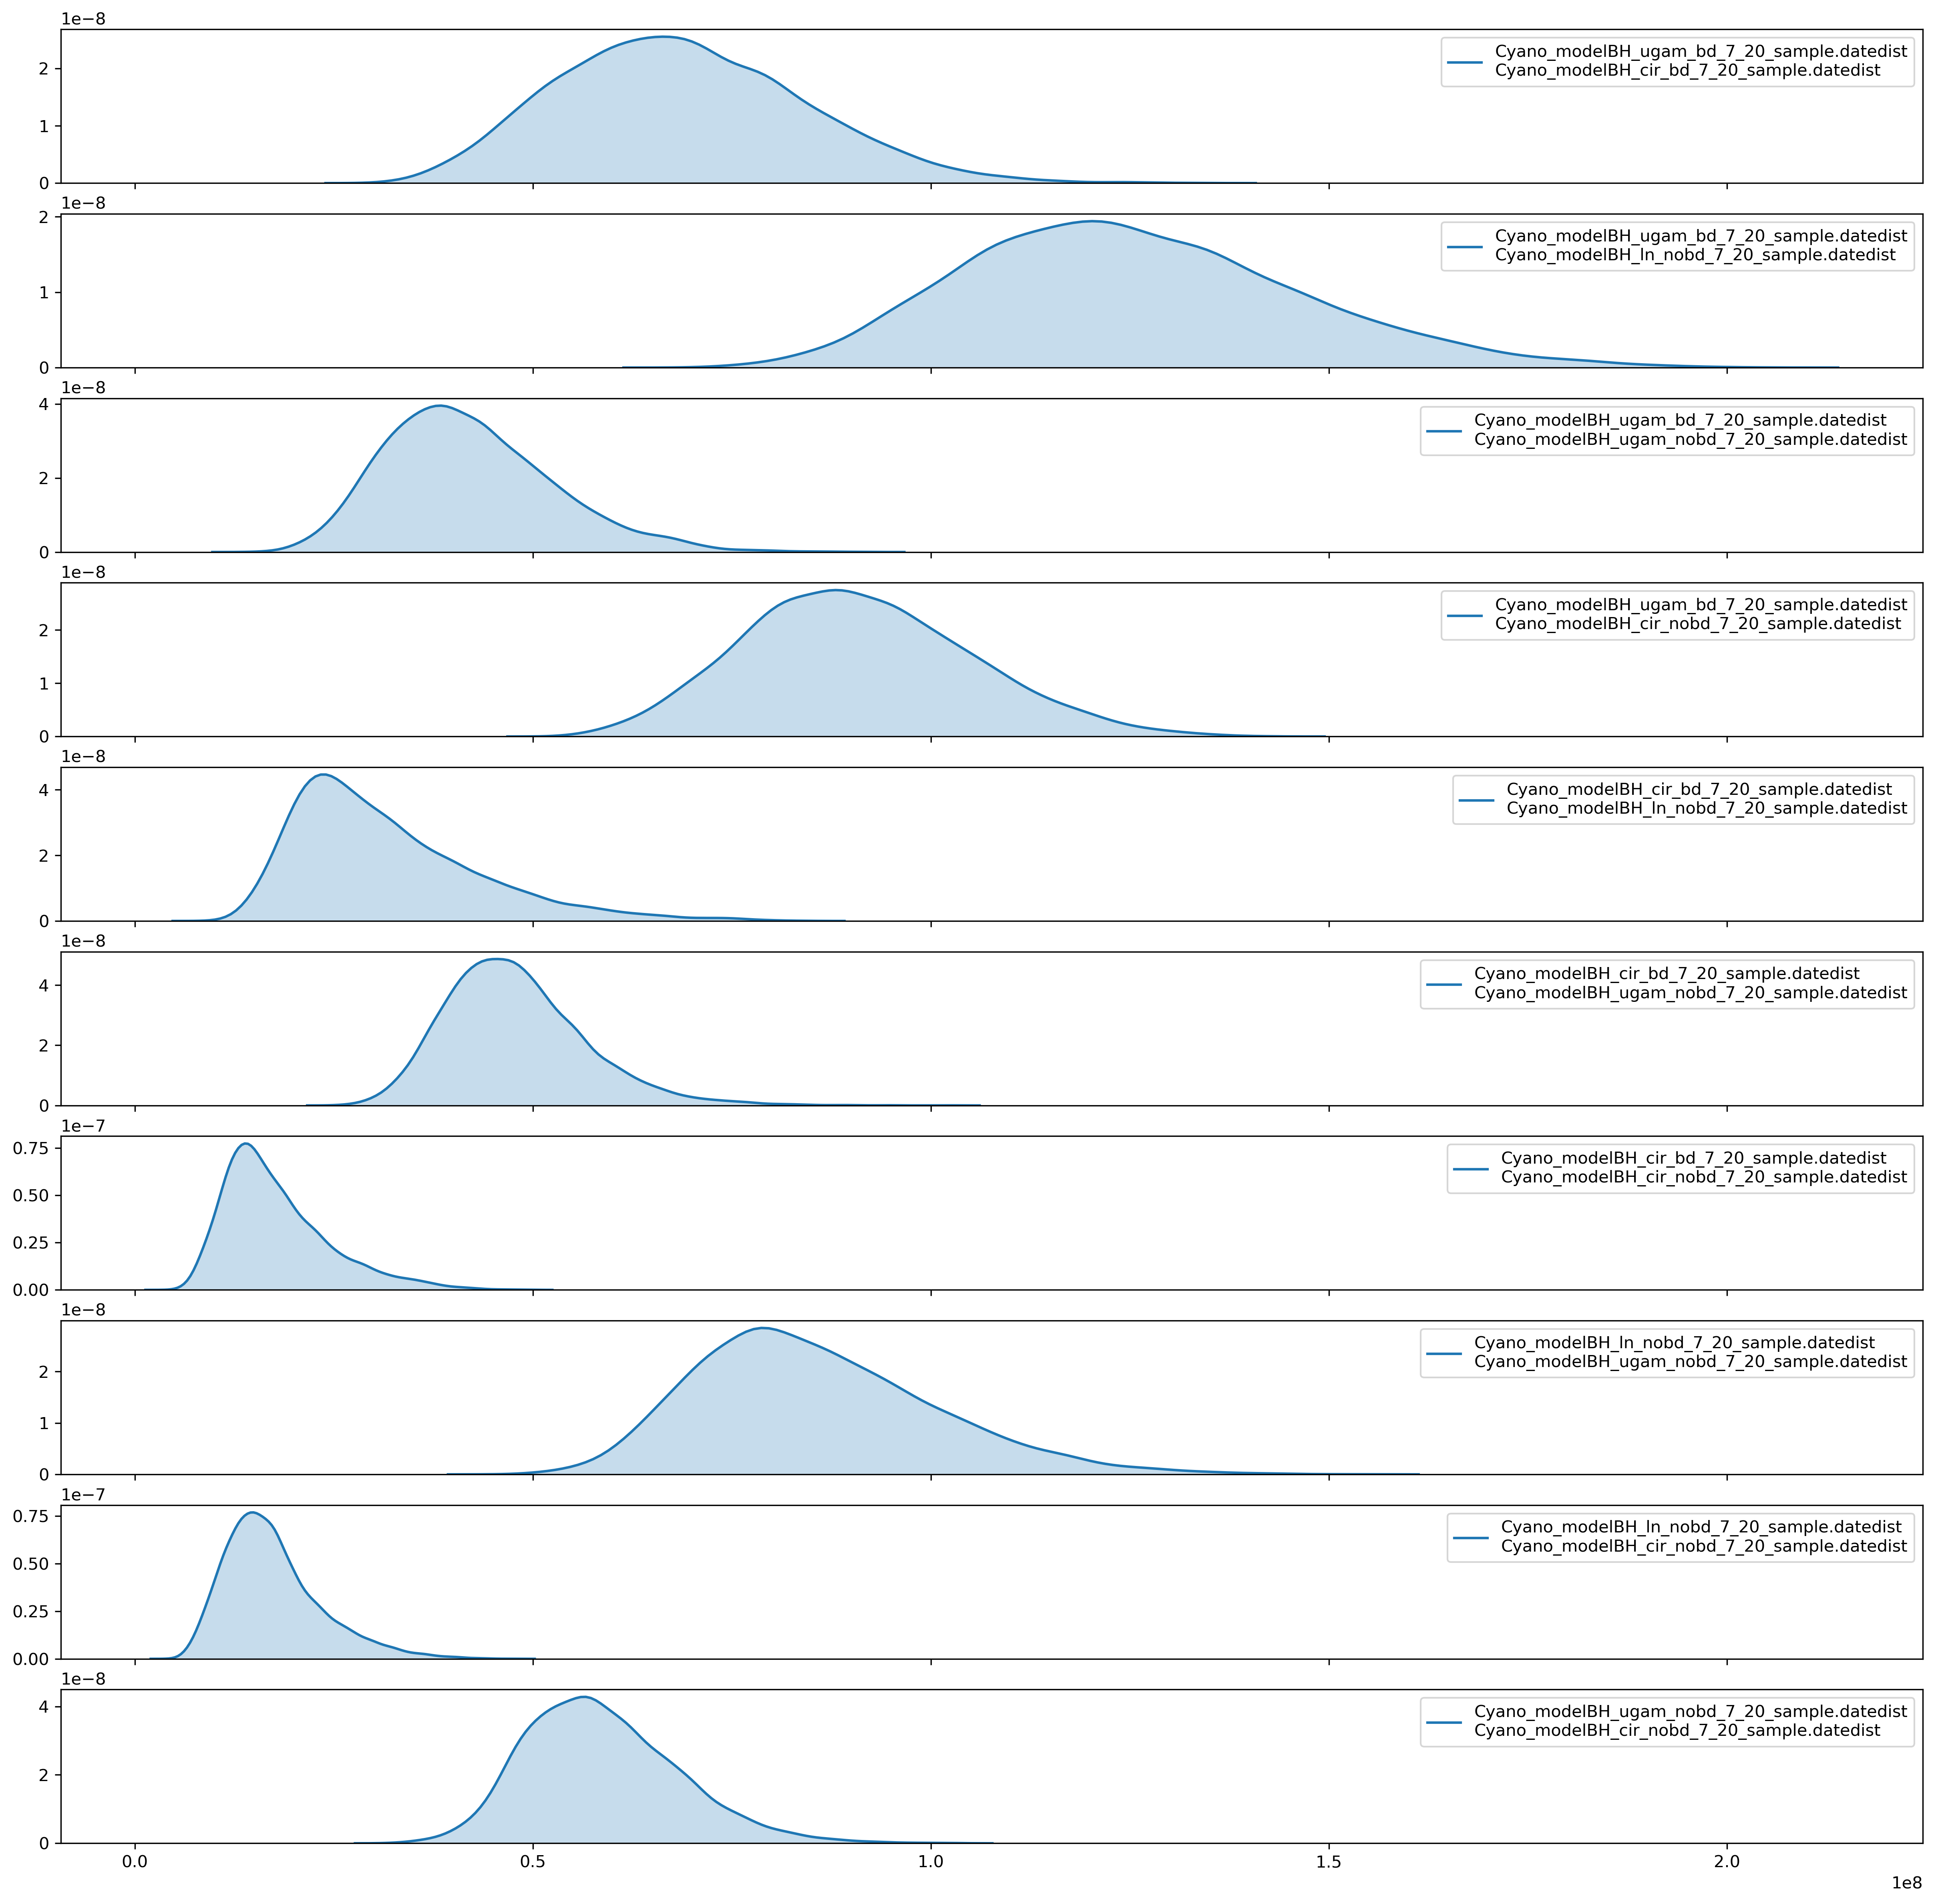

In [114]:
fig, axs = plt.subplots(nrows=10, sharex=True, dpi=300, figsize=(20,20))

for (datedists, residuals), ax in zip(sse.items(), axs):
    sns.kdeplot(residuals, shade=True, ax=ax, label='%s\n%s' % datedists)

In [28]:
tmp            = list(transfer_df.groupby(['donor', 'recipient']).groups.keys())
constraints    = np.empty(len(tmp), dtype='O')
constraints[:] = tmp

In [32]:
def assess_constraint_compatibility(constraint):
    older_bound   = next(
        next(
            tree.iter_search_nodes(name=constraint[0])
        ).iter_ancestors()
    )
    younger_bound = next(tree.iter_search_nodes(name=constraint[1]))
    
    compatibilities = []
    for tmp_tree in posterior_trees:
        older_bound_age   = get_node_age_from_descendants(tmp_tree,   older_bound.get_leaf_names())
        younger_bound_age = get_node_age_from_descendants(tmp_tree, younger_bound.get_leaf_names())
        
        if older_bound_age > younger_bound_age:
            compatibilities.append(True)
        else:
            compatibilities.append(False)

    return(compatibilities)

In [33]:
compatibility_tables = {}
compatibility_count  = pd.DataFrame(index=constraints)

for datedist, posterior_trees in posterior_tree_sample.items():
    pool    = multiprocessing.Pool(processes=20)
    results = pool.map(assess_constraint_compatibility, constraints)

    compatibility_tables[datedist] = pd.DataFrame(columns=constraints,
                                                  data   =np.array(results).T)

    compatibility_count[datedist]      = compatibility_tables[datedist].sum()

In [34]:
compatibility_count.head()

,Cyano_modelBH_ugam_bd_7_20_sample.datedist,Cyano_modelBH_cir_bd_7_20_sample.datedist,Cyano_modelBH_ln_nobd_7_20_sample.datedist,Cyano_modelBH_ugam_nobd_7_20_sample.datedist,Cyano_modelBH_cir_nobd_7_20_sample.datedist
"(n100, n106)",100,100,100,100,100
"(n100, n108)",100,100,100,100,100
"(n100, n114)",96,100,100,92,100
"(n100, n56)",100,100,100,100,100
"(n100, n71)",21,0,0,21,0


In [41]:
pairwise_dists = {}
for i,j in sse.keys():
    desc_i   = '-'.join(re.search('Cyano_modelBH_([^_]+)_([^_]+)', i).groups())
    desc_j   = '-'.join(re.search('Cyano_modelBH_([^_]+)_([^_]+)', j).groups())
    tmp_dist = braycurtis(compatibility_count[i], compatibility_count[j])
    print('%s VS %s: %.4f' %(desc_i,
                          desc_j,
                          tmp_dist)
         )
    pairwise_dists[i, j] = tmp_dist

ugam-bd VS cir-bd: 0.0736
ugam-bd VS ln-nobd: 0.0855
ugam-bd VS ugam-nobd: 0.0325
ugam-bd VS cir-nobd: 0.0830
cir-bd VS ln-nobd: 0.0261
cir-bd VS ugam-nobd: 0.0588
cir-bd VS cir-nobd: 0.0251
ln-nobd VS ugam-nobd: 0.0647
ln-nobd VS cir-nobd: 0.0276
ugam-nobd VS cir-nobd: 0.0703


In [101]:
constraint_dissimilarity      = []
avg_br_length_error      = []
std_br_length_error      = []
labels = []
compared_models = []
compared_priors = []
for model_pair in sse.keys():

    model1, prior1 = re.search('Cyano_modelBH_([^_]+)_([^_]+)', model_pair[0]).groups()
    model2, prior2 = re.search('Cyano_modelBH_([^_]+)_([^_]+)', model_pair[1]).groups()
    
    tmp = [model1, model2]
    tmp.sort()    
    compared_models.append(' VS '.join(tmp ))

    tmp = [prior1, prior2]
    tmp.sort()    
    compared_priors.append(' VS '.join(tmp))
        
    constraint_dissimilarity.append(pairwise_dists[model_pair])
    avg_br_length_error.append(np.mean(sse[model_pair]))
    std_br_length_error.append(np.std(sse[model_pair]))

model_comparison_df = pd.DataFrame(columns=['constraint fitting dissimilarity',
                                            'avg. sum of squared br. length differences',
                                            'std sum of squared br. length differences',
                                            'Compared Models',
                                            'Compared Priors'],
                                   data=zip(constraint_dissimilarity,
                                            avg_br_length_error,
                                            std_br_length_error,
                                            compared_models,
                                            compared_priors)
                                  )

In [110]:
model_comparison_df

,constraint fitting dissimilarity,avg. sum of squared br. length differences,std sum of squared br. length differences,Compared Models,Compared Priors
0,0.073566,6.857891e+07,1.516413e+07,cir VS ugam,bd VS bd
1,0.085450,1.252957e+08,2.054131e+07,ln VS ugam,bd VS nobd
2,0.032495,4.196233e+07,1.048534e+07,ugam VS ugam,bd VS nobd
3,0.082983,9.085826e+07,1.416328e+07,cir VS ugam,bd VS nobd
4,0.026076,3.150960e+07,1.149204e+07,cir VS ln,bd VS nobd
5,0.058832,4.777280e+07,8.690226e+06,cir VS ugam,bd VS nobd
6,0.025123,1.779042e+07,6.610532e+06,cir VS cir,bd VS nobd
7,0.064701,8.543123e+07,1.486872e+07,ln VS ugam,nobd VS nobd
8,0.027570,1.730535e+07,6.027498e+06,cir VS ln,nobd VS nobd
9,0.070337,5.872249e+07,9.581845e+06,cir VS ugam,nobd VS nobd


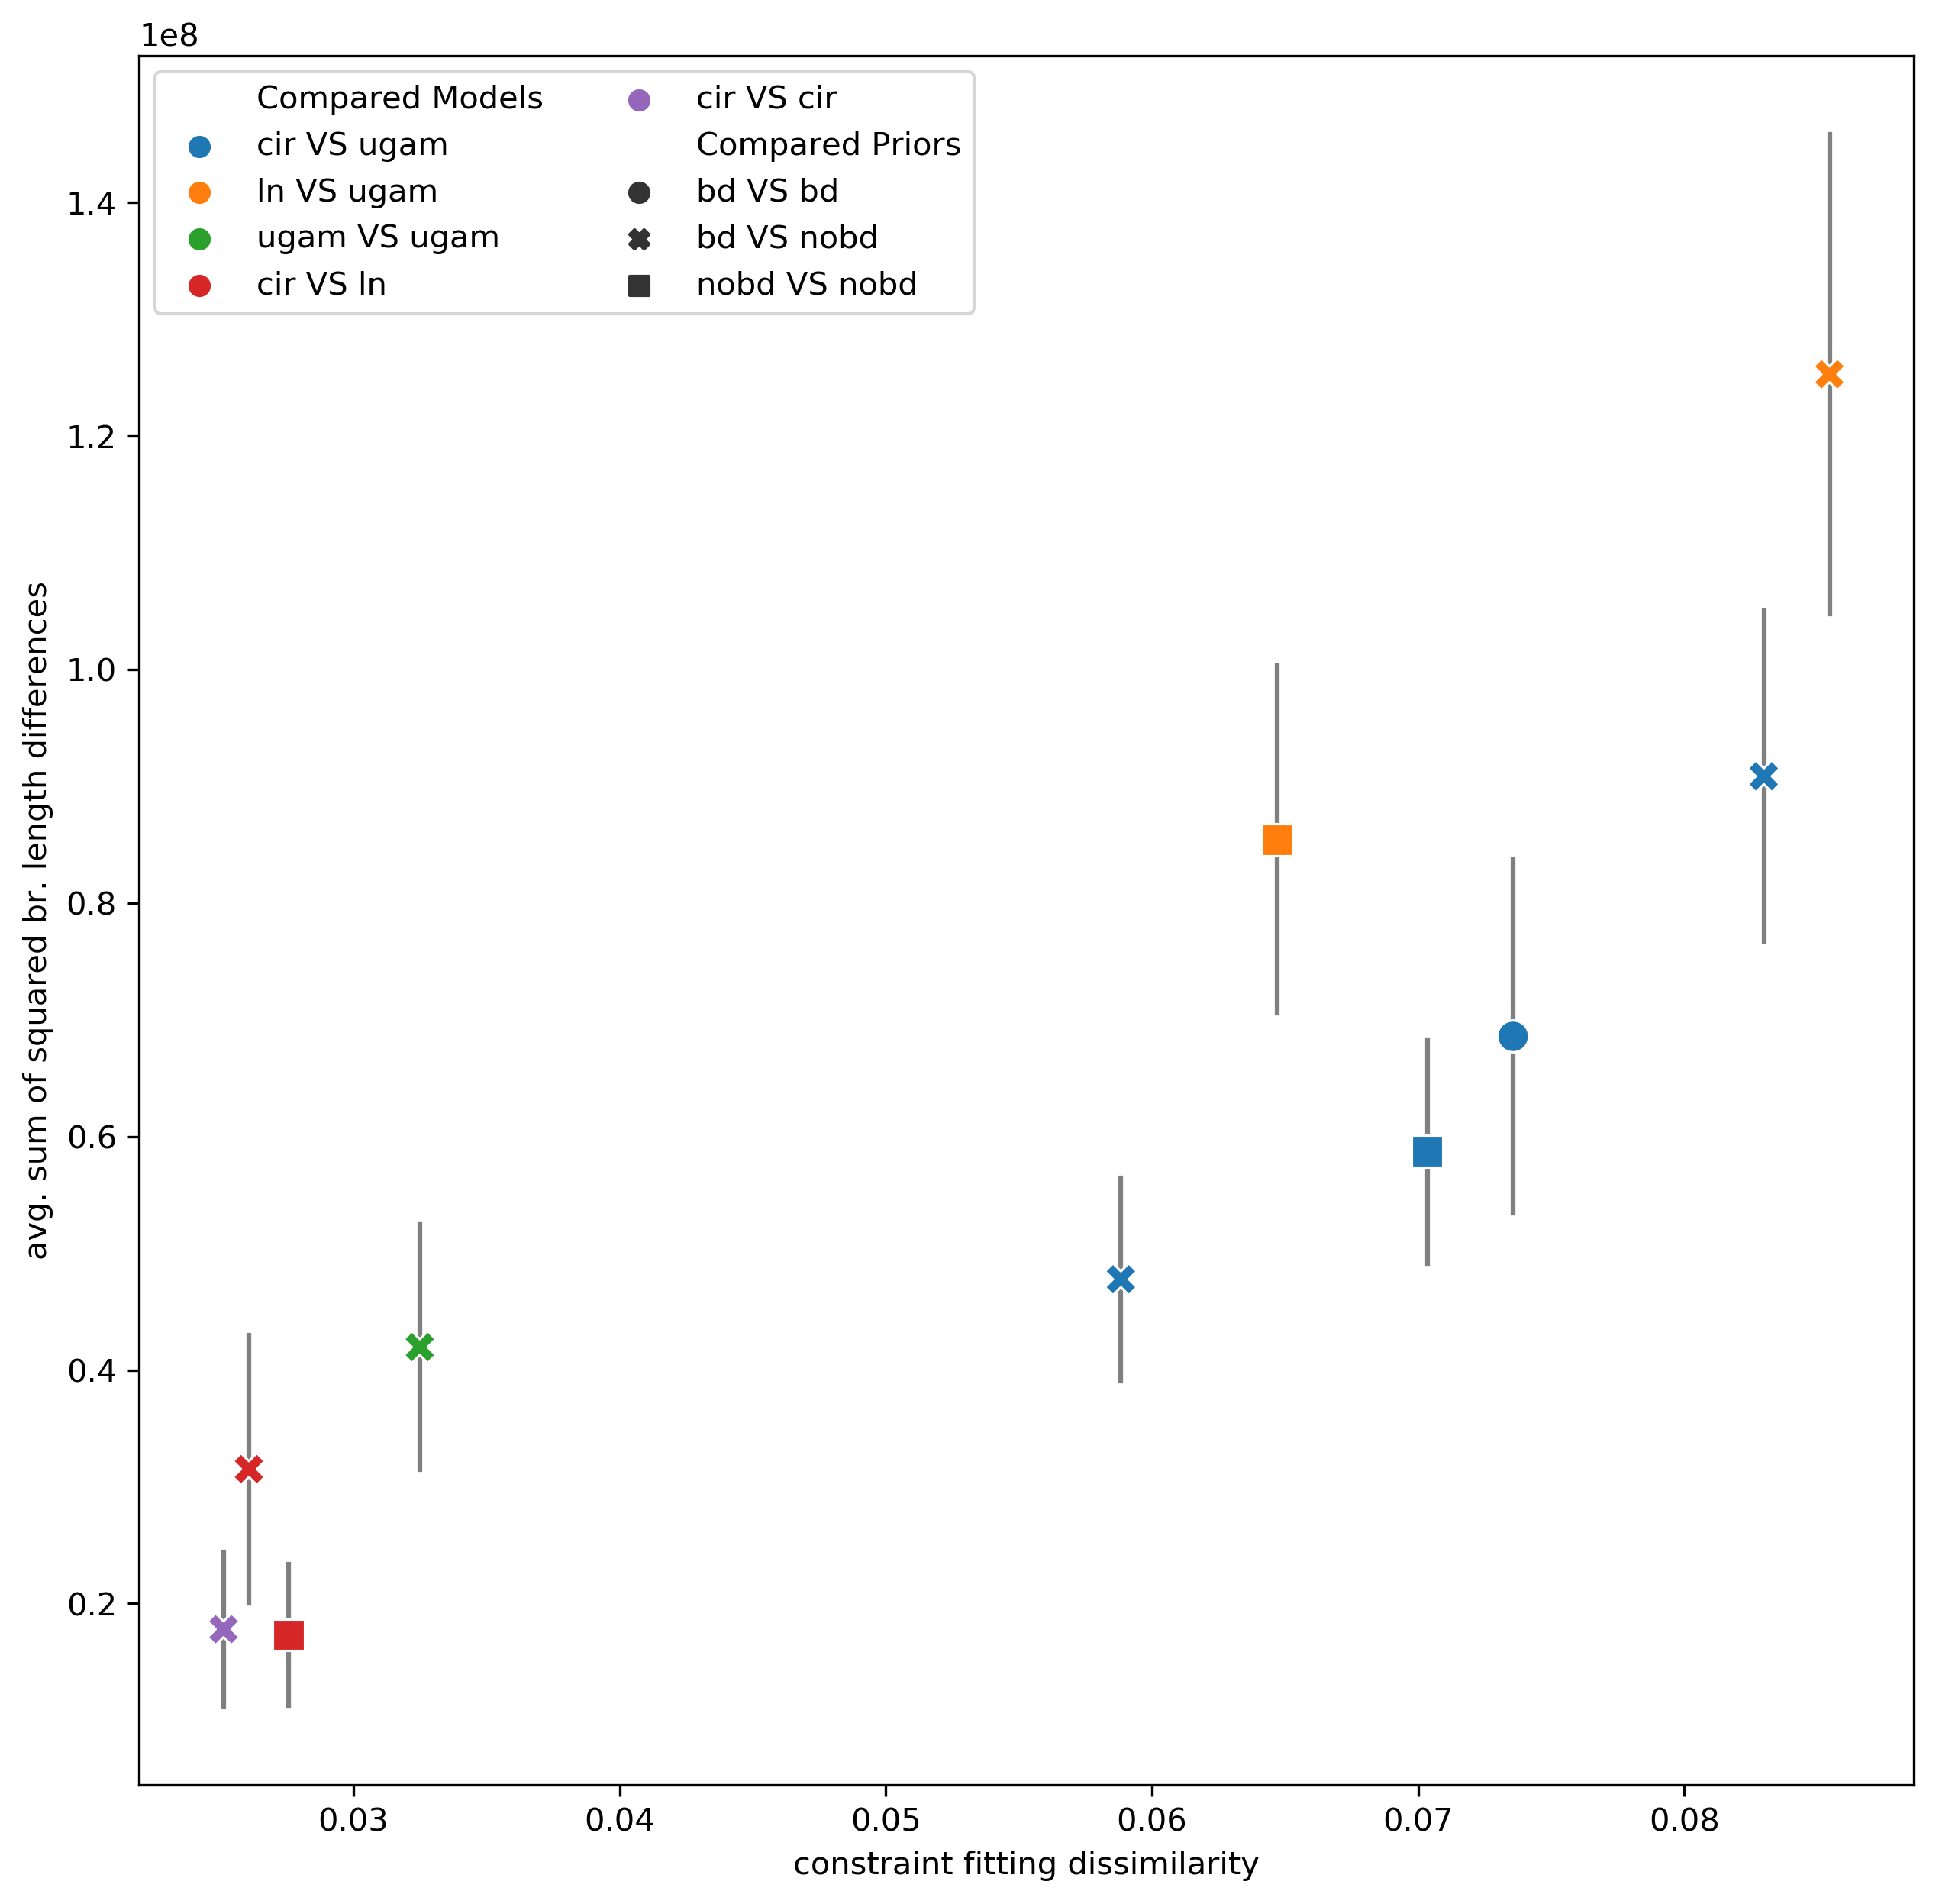

In [109]:
fig, ax = plt.subplots(dpi=300, figsize=(10, 10))

for index, row in model_comparison_df.iterrows():
    ax.plot([row['constraint fitting dissimilarity'], row['constraint fitting dissimilarity']],
            [row['avg. sum of squared br. length differences'] - row['std sum of squared br. length differences'],
             row['avg. sum of squared br. length differences'] + row['std sum of squared br. length differences']
            ],
            c='grey',
            zorder=0)
    
sns.scatterplot(x='constraint fitting dissimilarity', 
                y='avg. sum of squared br. length differences', 
                data=model_comparison_df,
                hue='Compared Models',
                style='Compared Priors',
                s=100,
                ax=ax);

ax.legend(ncol=2);

In [266]:
uninformative_constraints = compatibility_count.index[(compatibility_count>=90).T.all()]
uninformative_constraints = list(uninformative_constraints)

uninformative_constraints.extend(compatibility_count.index[(compatibility_count<=10).T.all()])
uninformative_constraints = set(uninformative_constraints)

tmp                        = [constraint for constraint in constraints
                              if constraint not in uninformative_constraints]
informative_constraints    = np.empty(len(tmp), dtype='O')
informative_constraints[:] = tmp

In [268]:
def jaccard_between_constraints(constraints):
    intersection = sum(compatibility_table[constraints].T.all())
    union        = sum(compatibility_table[constraints].T.any())
    
    if not union:
        return(0.0)
    else:
        return(intersection/union)

In [269]:
pairs_of_constraints = [list(pair) for pair in itertools.combinations(
    informative_constraints,
    2)
]

In [270]:
similarity_between_constraints = {}
for datedist, compatibility_table in compatibility_tables.items():
    pool                = multiprocessing.Pool(processes=20)
    condensed_distances = np.array(
        pool.map(jaccard_between_constraints, pairs_of_constraints)
    )

    similarity_between_constraints[datedist] = pd.DataFrame(index  =informative_constraints,
                                                            columns=informative_constraints,
                                                            data   =squareform(condensed_distances)
                                                           )

In [271]:
clusters = {}
for datedist, matrix in similarity_between_constraints.items():
    tmp_df         = matrix.copy()
    tmp_df.index   = range(matrix.shape[0])
    tmp_df.columns = range(matrix.shape[0])
    
    graph   = nx.convert_matrix.from_pandas_adjacency(tmp_df)
    louvain = community.best_partition(graph, random_state=12345)
    
    tmp = []
    for count, constraint in enumerate(matrix):
        tmp.append(louvain[count])
    clusters[datedist] = np.asarray(tmp)

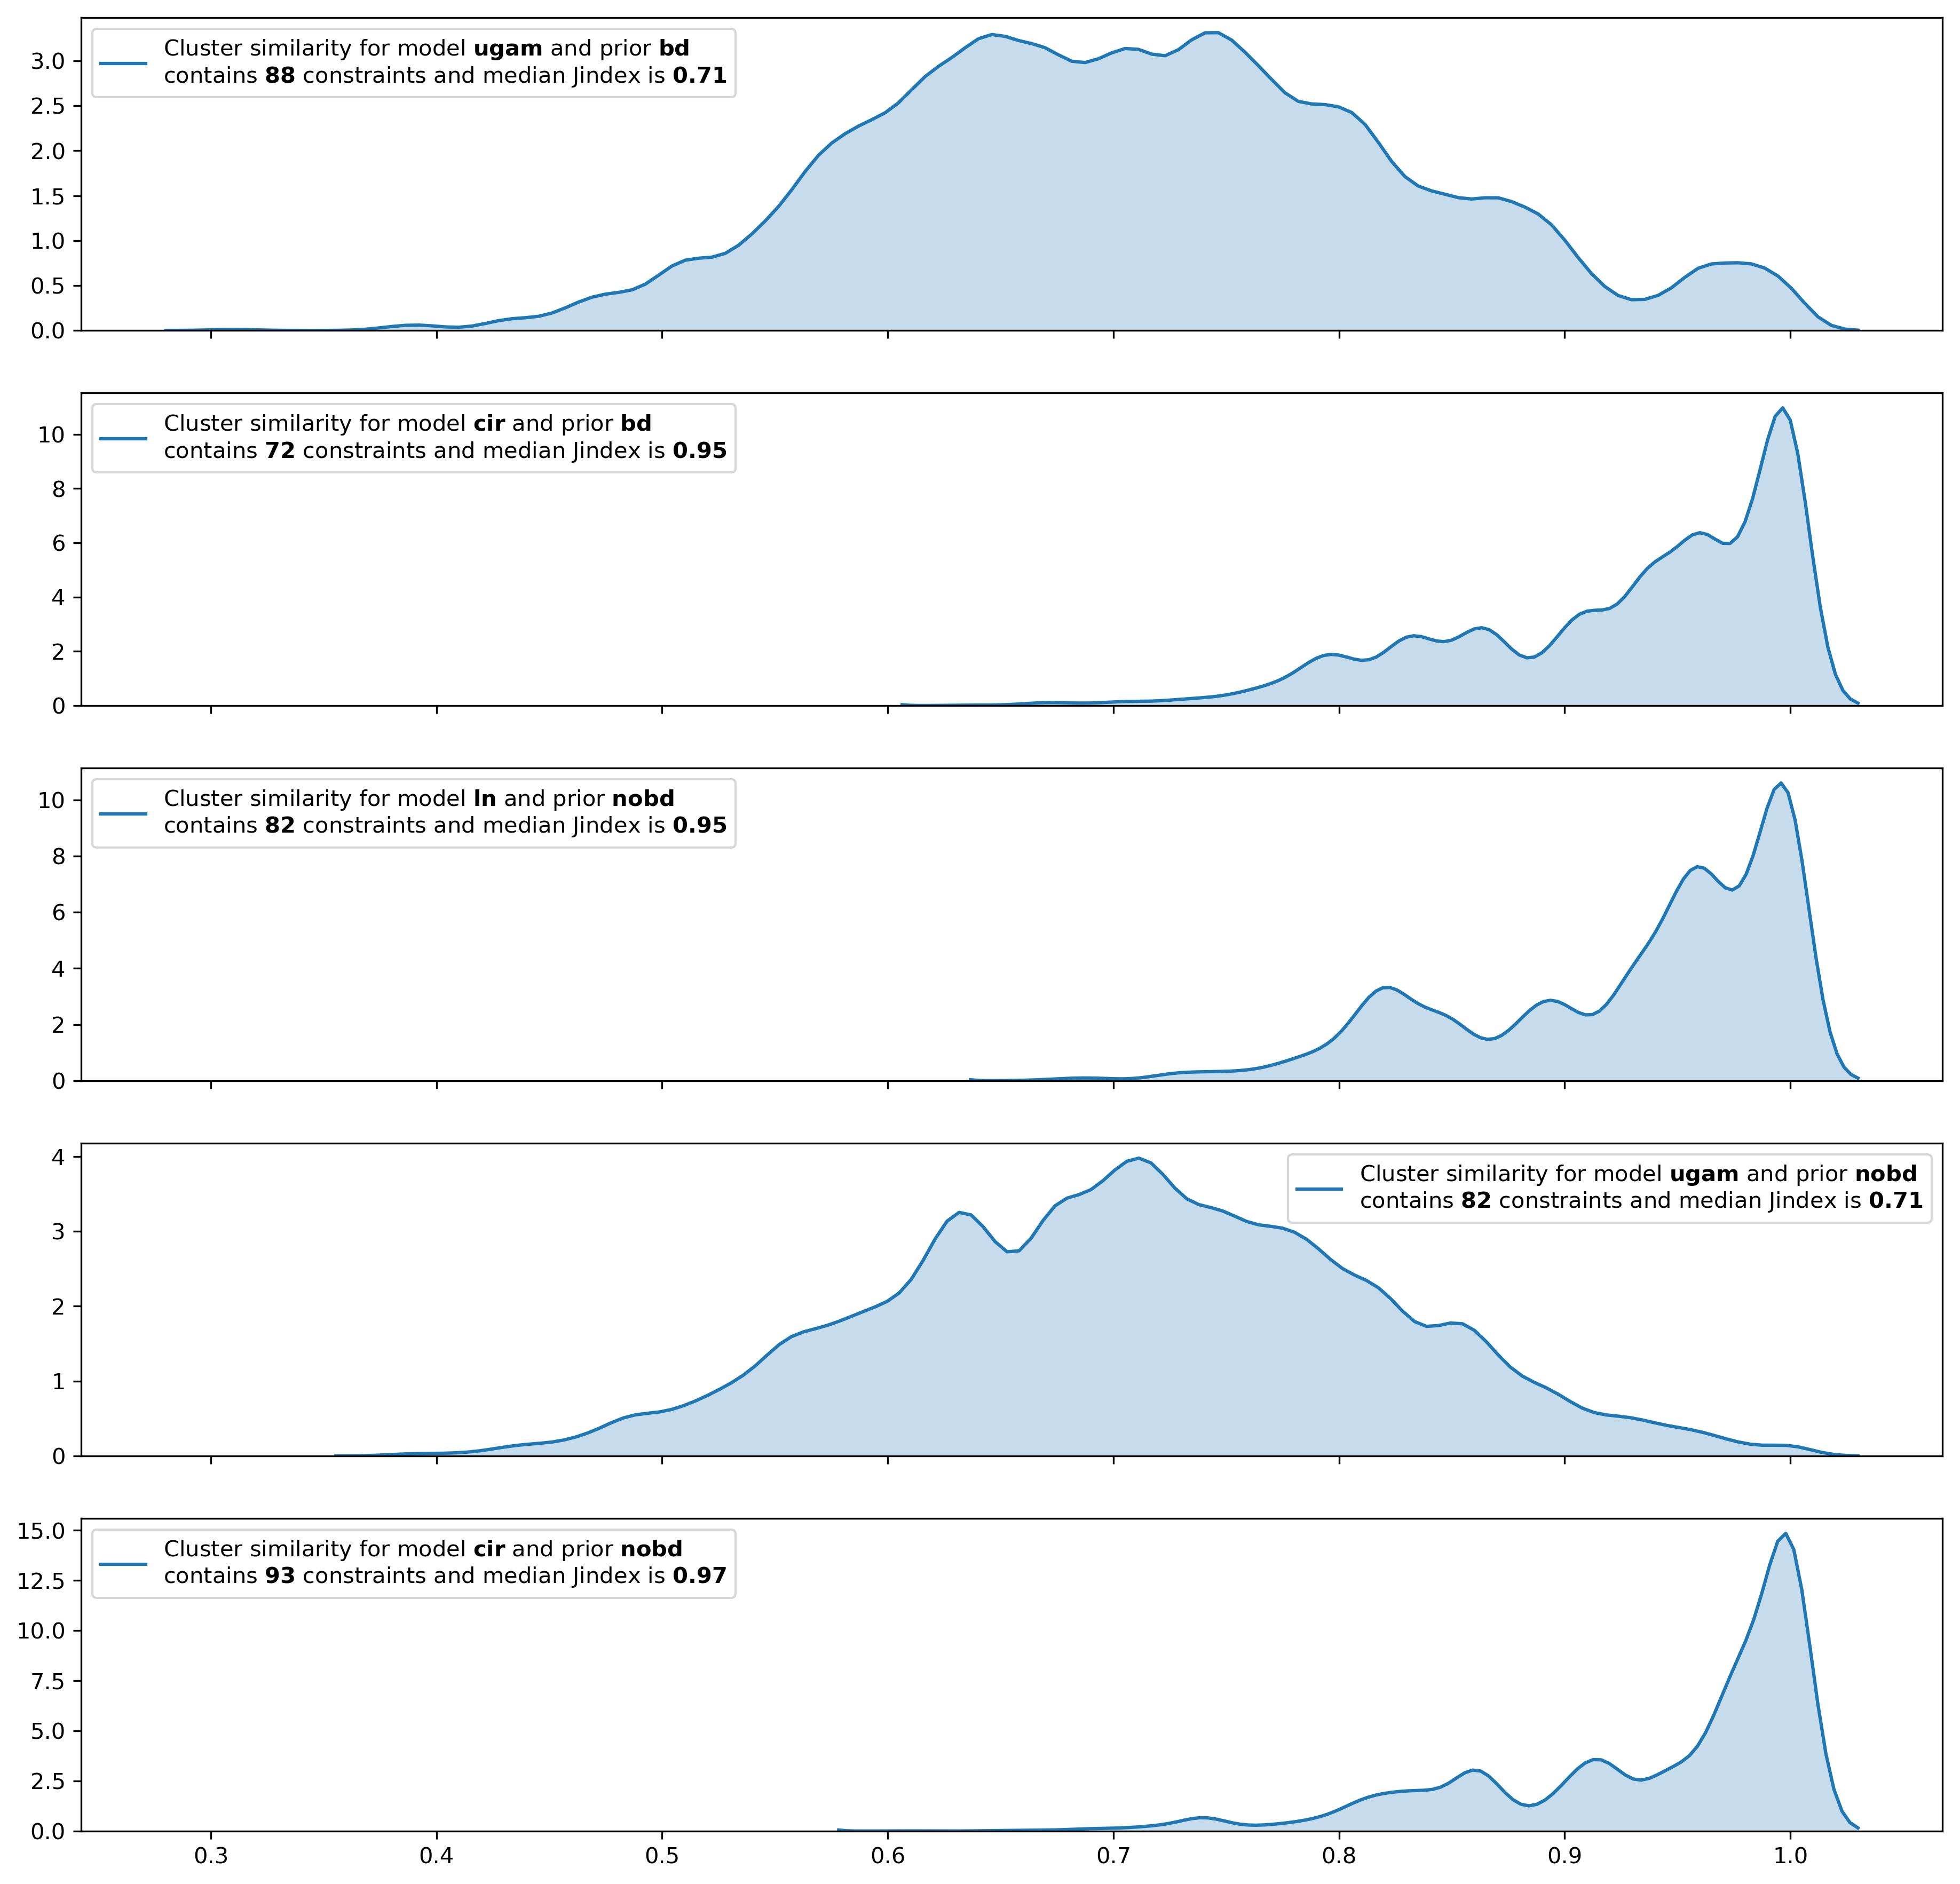

In [324]:
fig, axs      = plt.subplots(nrows=5, figsize=(15,15), sharex=True, dpi=300)

for (datedist, cluster), ax in zip(clusters.items(), axs):
    main_cluster_id = sorted(Counter(cluster),
                             key=Counter(cluster).__getitem__,
                             reverse=True)[0]
    
    tmp_constraints = informative_constraints[clusters[datedist]==main_cluster_id]
    main_clusters[datedist] = tmp_constraints
    condensed_similarities = squareform(
        similarity_between_constraints[datedist].reindex(index  =tmp_constraints,
                                                         columns=tmp_constraints).values
    )

    tmp_model, tmp_prior = re.search('Cyano_modelBH_([^_]+)_([^_]+)', datedist).groups()

    sns.kdeplot(condensed_similarities,
                bw=0.01,
                shade=True,
                ax=ax,
                label="""\
Cluster similarity for model $\\bf{%s}$ and prior $\\bf{%s}$
contains $\\bf{%i}$ constraints and median Jindex is $\\bf{%.2f}$""" %
                (tmp_model, tmp_prior, len(tmp_constraints), np.median(condensed_similarities))
               );

In [421]:
def jaccard_and_hypergeom_between_constraints(constraints):
    intersection = sum(compatibility_table[constraints].T.all())
    union        = sum(compatibility_table[constraints].T.any())
    
    num_compatible_constraint_1 = compatibility_table[constraints[0]].sum()
    num_compatible_constraint_2 = compatibility_table[constraints[1]].sum()
    
    pval = hypergeom.sf(intersection, 100, num_compatible_constraint_1, num_compatible_constraint_2)
    
    if not union or not intersection:
        return(0.0, 1.0)
    else:
        return(intersection/union, pval)

In [420]:
for constraint in pairs_of_constraints[:10000]:

    num_compatible_constraint_1 = compatibility_table[constraint[0]].sum()
    num_compatible_constraint_2 = compatibility_table[constraint[1]].sum()
    
    if num_compatible_constraint_1 == 100 or num_compatible_constraint_2 == 100:
        continue

    if num_compatible_constraint_1 == 0 or num_compatible_constraint_2 == 0:
        continue

    intersection = sum(compatibility_table[constraint].T.all())
    union        = sum(compatibility_table[constraint].T.any())

    pval = hypergeom.pmf(intersection, 100, num_compatible_constraint_1, num_compatible_constraint_2)+\
           hypergeom.sf(intersection, 100, num_compatible_constraint_1, num_compatible_constraint_2)

    if pval > 0.1:
        continue
    print(intersection,
          num_compatible_constraint_1,
          num_compatible_constraint_2,
          pval
         )

63 64 95 0.05508100147275415
28 64 38 0.08524357972733165
17 50 27 0.08798799325773055
50 50 92 0.0028850810098075357
22 50 36 0.07213530458102316
43 50 47 2.762288682306131e-16
29 50 40 0.00022449753449826015
20 50 29 0.013302600793225847
25 50 39 0.019852174166026918
13 50 16 0.006108799146462804
50 50 94 0.013330538154195302
17 50 25 0.03171098297118941
11 50 13 0.007338845538870449
45 50 82 0.03321456310281154
39 50 62 0.0009073670075149158
50 50 96 0.058731646360512264
8 50 10 0.04582357764406663
50 50 95 0.02814224721441218
13 50 13 4.9906250980149715e-05


In [424]:
condensed_similarities.shape

(4278,)

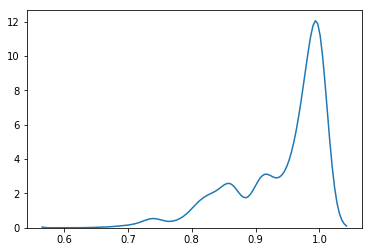

In [423]:
sns.kdeplot(condensed_similarities)